<a href="https://colab.research.google.com/github/dieko95/AlgoTrading/blob/develop/Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

#### Install Library

In [1]:
### Install bt package

!pip install bt
!pip install pydrive

     |████████████████████████████████| 2.7MB 42.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
     |████████████████████████████████| 993kB 45.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


### Authenticate Google 

In [0]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


### Load Data from Drive 

In [0]:
import pandas as pd  

file_id = '1hA1Iq3N-T84Gq6xZm1WDhcycCxqay16Z'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')

Return = pd.read_csv('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')

## Index as TimeStamp DateTime type 



In [4]:
Return.timeStamp = pd.to_datetime(Return.timeStamp) 
Return.set_index(Return["timeStamp"],inplace=True)

# Return = Return['predictedReturns']
Return.head()

,Unnamed: 0,timeStamp,predictedReturns
timeStamp,,,
2014-01-02,0,2014-01-02,-0.000896
2014-01-03,1,2014-01-03,0.010039
2014-01-04,2,2014-01-04,0.000000
2014-01-05,3,2014-01-05,0.000000
2014-01-06,4,2014-01-06,0.019169


## Creating the Strategy

In [0]:
# Creating Signal Variable
signal = Return['predictedReturns'] 
signal = pd.DataFrame(signal)
signal = signal.rename(columns={'predictedReturns':'rht'})

# Creating Weights 
tw = signal.copy()


# Assign weight number for each type of signal strength
WeightStrongLong = 1.0
WeightMediumLong = 0.5
WeightWeak = 0
WeightMediumShort = -0.5
WeightStrongShort = -1.0


# Match the signal strength with the assigned weight
tw[signal > 0.02 ] = WeightStrongLong
tw[(signal >= 0.01) & (signal <= 0.02)] = WeightMediumLong
tw[(signal >= -0.01) & (signal <= 0.01)] = WeightWeak
tw[(signal <= -0.01) & (signal >= -0.02)] = WeightMediumShort
tw[signal < -0.02] = WeightStrongShort
tw[tw.isnull()] = 0 




In [0]:
# This one works with the lagging



# class Signal(bt.Algo):

#     """
    
#     Mostly copied from StatTotalReturn
    
#     Sets temp['Signal'] with total returns over a given period.

#     Sets the 'Signal' based on the total return of each
#     over a given lookback period.

#     Args:
#         * lookback (DateOffset): lookback period.
#         * lag (DateOffset): Lag interval. Total return is calculated in
#             the inteval [now - lookback - lag, now - lag]

#     Sets:
#         * stat

#     Requires:
#         * selected

#     """

#     def __init__(self, lookback=pd.DateOffset(months=3),
#                  lag=pd.DateOffset(days=0)):
#         super(Signal, self).__init__()
#         self.lookback = lookback
#         self.lag = lag

#     def __call__(self, target):
#         selected = 'rht'
#         t0 = target.now - self.lag
        
#         if target.universe[selected].index[0] > t0:
#             return False
#         prc = target.universe[selected].loc[t0 - self.lookback:t0]
        
        
#         trend = prc.iloc[-1]/prc.iloc[0] - 1
#         signal = trend > 0.
        
#         if signal:
#             target.temp['Signal'] = 1.
#         else:
#             target.temp['Signal'] = 0.
            
#         return True

# signalAlgo = Signal(pd.DateOffset(months=12),pd.DateOffset(days=15))


In [0]:
%matplotlib inline


#import bt package
import bt

# fetch some data
data = bt.get( 'rht', start='2014-01-02', end= '2018-12-30')


#data['predictedReturns'] = Return['predictedReturns']


# signal = Return['predictedReturns'] #> 0.01

# signal = pd.DataFrame(signal)
# signal = signal.rename(columns={'predictedReturns':'rht'})


# # create the strategy
s1 = bt.Strategy('s1', [bt.algos.SelectWhere(signal),
#                         signalAlgo,
                        bt.algos.StatTotalReturn(lookback=pd.DateOffset(months=12),lag=pd.DateOffset(days=1)), # it needs to be after  selectwhere IT DOESNT WORK 
#                         bt.algos.bt.algos.SelectMomentum(n=1, lookback= pd.DateOffset(months=1)), # With email from professor
                        bt.algos.WeighTarget(tw),
                        bt.algos.LimitDeltas(), 
                        bt.algos.Rebalance()])



# Include Default comissions, we have realistic comissions

# s1.adjust(1000000,fee=0.1)
# # s1.commission_fn(getFee(10,5))

s1
0% [############################# ] 100% | ETA: 00:00:00Stat                 s1
-------------------  ----------
Start                2014-01-01
End                  2018-12-28
Risk-free rate       0.64%

Total Return         126.42%
Daily Sharpe         1.94
Daily Sortino        2.41
CAGR                 17.80%
Max Drawdown         -19.12%
Calmar Ratio         0.93

MTD                  2.00%
3m                   -12.63%
6m                   -13.28%
YTD                  -0.11%
1Y                   -0.11%
3Y (ann.)            13.78%
5Y (ann.)            17.80%
10Y (ann.)           17.80%
Since Incep. (ann.)  17.80%

Daily Sharpe         1.94
Daily Sortino        2.41
Daily Mean (ann.)    16.75%
Daily Vol (ann.)     8.29%
Daily Skew           -12.75
Daily Kurt           356.70
Best Day             4.63%
Worst Day            -13.34%

Monthly Sharpe       1.95
Monthly Sortino      2.79
Monthly Mean (ann.)  16.59%
Monthly Vol (ann.)   8.19%
Monthly Skew         -2.95
Monthly Kurt        

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


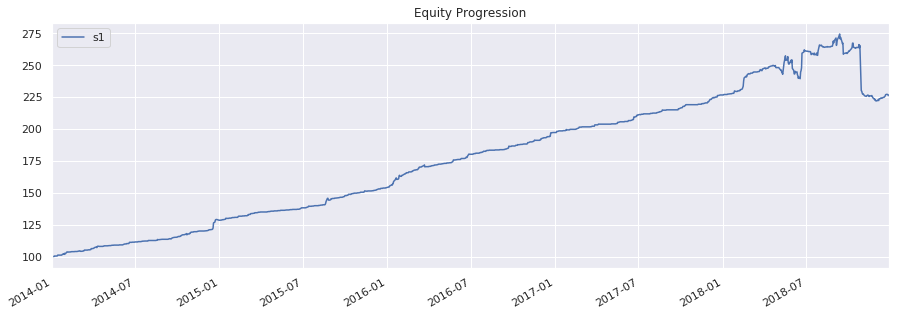

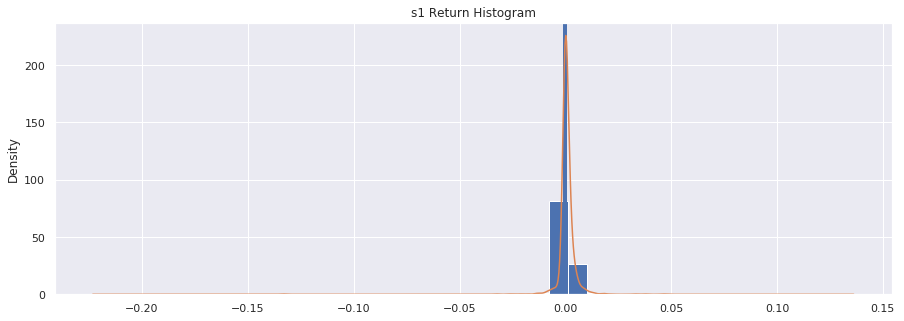

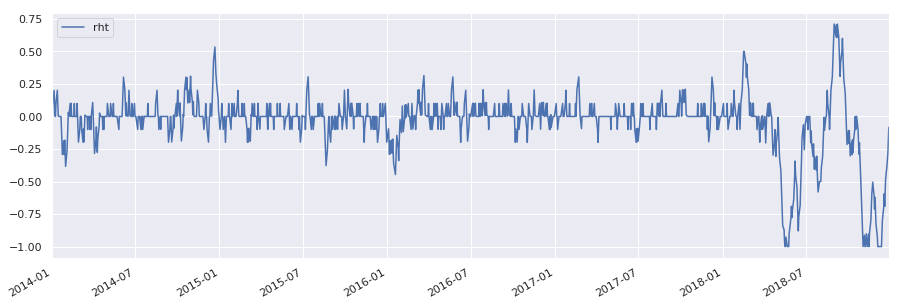

In [12]:
%matplotlib inline

import seaborn as sns
sns.set()


# We will need the risk-free rate to get correct Sharpe Ratios 
riskfree =  bt.get('^IRX', start= '2014-01-01', end= '2018-12-31')
# Take the average of the risk free rate over entire time period
riskfree_rate = float(riskfree.mean()) / 100



# create a backtest and run it
test = bt.Backtest(s1, data, commissions=lambda q, p: max(1, abs(q) * 0.01))
res = bt.run(test)

res.set_riskfree_rate(riskfree_rate)

# first let's see an equity curve
res.plot()

# ok and what about some stats?
res.display()

# ok and how does the return distribution look like?
res.plot_histogram()

# and just to make sure everything went along as planned, let's plot the security weights over time
res.plot_security_weights()


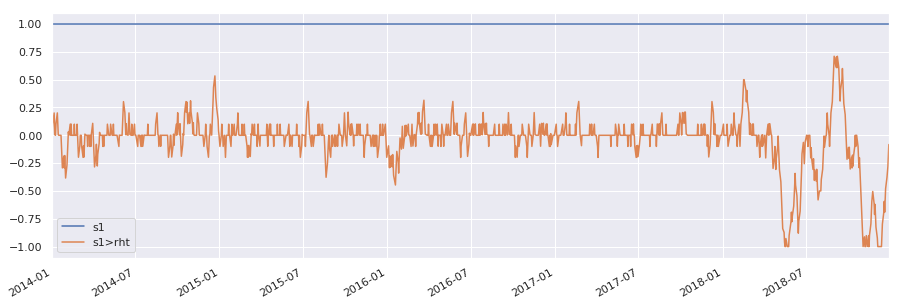

In [0]:
sns.set()
res.plot_weights() # Ask professor why there's a constant (blue line)

In [0]:
# s1.commission_fn()

In [0]:
# def getFee(quantity, price):
#     rate = 0.0003
#     fee = quantity*price*rate
#     if fee < 0.1:
#         fee = 0.1
#     return fee


In [0]:
res.display_lookback_returns()


,s1
mtd,2.00%
3m,-12.63%
6m,-13.28%
ytd,-0.11%
1y,-0.11%
3y,13.78%
5y,17.80%
10y,17.80%
incep,17.80%


## Getting Transactions per Day

In [0]:

# Get Transactions
trans = res.get_transactions()
trans.head()

,,price,quantity
Date,Security,,
2014-01-03,rht,55.779999,1792.0
2014-01-06,rht,56.340000,1776.0
2014-01-07,rht,57.419998,-1751.0
2014-01-08,rht,56.990002,-1763.0
2014-01-09,rht,57.290001,-54.0
